In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import time
# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder

#Import hyperparameter optimization packages
#If either are not installed, give a warning
try:
    from bayes_opt import BayesianOptimization
except ImportError:
    print("\nWARNING: BayesianOptimization package is not installed. You will be unable to use section 4.")
    pass

try:
    from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
except ImportError:
    print("\nWARNING: hyperopt package is not installed. You will be unable to use section 5.")
    pass



In [7]:
###Load Data###
folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/' 
data=io.loadmat(folder+'jeb7_decoding_lfads.mat')

rates_lfads = data['rates_lfads']
factors_lfads = data['factors_lfads']
rates_smooth = data['rates_smooth']
factors_smooth = data['factors_smooth']
jawPos = data['jawPos']
jawVel = data['jawVel']
jawAcc = data['jawAcc']

In [10]:
print(rates_lfads.shape)
print(rates_smooth.shape)
print(factors_lfads.shape)
print(factors_smooth.shape)

(67760, 65)
(67760, 65)
(67760, 10)
(67760, 10)


In [44]:
bins_before=int(.1/.005) #How many bins of neural data prior to the output are used for decoding
# 100 ms lag with 5 ms bins
bins_current=0 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

In [45]:
###$$ GET_SPIKES_WITH_HISTORY #####
def my_get_spikes_with_history(neural_data,bins_before,bins_after,bins_current=1):
    """
    Function that creates the covariate matrix of neural activity
    Parameters
    ----------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    bins_before: integer
        How many bins of neural data prior to the output are used for decoding
    bins_after: integer
        How many bins of neural data after the output are used for decoding
    bins_current: 0 or 1, optional, default=1
        Whether to use the concurrent time bin of neural data for decoding
    Returns
    -------
    X: a matrix of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
        For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after)
    """

    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_after+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = np.NaN
    #Loop through each time bin, and collect the spikes occurring in surrounding time bins
    #Note that the first "bins_before" and last "bins_after" rows of X will remain filled with NaNs, since they don't get filled in below.
    #This is because, for example, we cannot collect 10 time bins of spikes before time bin 8
    start_idx=0
    for i in range(num_examples-bins_before-bins_after): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i+bins_before,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        start_idx=start_idx+1;
    return X

In [68]:
def my_decoder(X,X_flat,y):
    #Set what part of data should be part of the training/testing/validation sets
    training_range=[0, 0.7]
    testing_range=[0.7, 0.85]
    valid_range=[0.85,1]
    num_examples=X.shape[0]

    #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
    #This makes it so that the different sets don't include overlapping neural data
    training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
    testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
    valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

    #Get training data
    X_train=X[training_set,:,:]
    X_flat_train=X_flat[training_set,:]
    y_train=y[training_set,:]

    #Get testing data
    X_test=X[testing_set,:,:]
    X_flat_test=X_flat[testing_set,:]
    y_test=y[testing_set,:]

    #Get validation data
    X_valid=X[valid_set,:,:]
    X_flat_valid=X_flat[valid_set,:]
    y_valid=y[valid_set,:]
    
    #Z-score "X" inputs. 
    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)
    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std
    X_valid=(X_valid-X_train_mean)/X_train_std

    #Z-score "X_flat" inputs. 
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

    #Zero-center outputs
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean
    y_valid=y_valid-y_train_mean
    
    #"degree" was determined during hyperparameter optimization
    degree = 2.6606840322709155
    model_wc=WienerCascadeDecoder(degree) #Declare model w/ fit hyperparameter
    print('Fitting Model...')
    model_wc.fit(X_flat_train,y_train) #Fit model on training data
    y_test_predicted_wc=model_wc.predict(X_flat_test) #Get test set predictions
    #Print R2 values on test set
    R2s_wc=get_R2(y_test,y_test_predicted_wc)
    print('R2s_wc:', R2s_wc)

    rho2s_wc=get_rho(y_test,y_test_predicted_wc)**2
    print('rho2s_wc:', rho2s_wc)
    
    return y_test_predicted_wc

    

# LFADS

In [89]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=my_get_spikes_with_history(rates_lfads,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Set decoding output
y=jawPos

y_test_pred_lfads_rates = my_decoder(X,X_flat,y)

#####################################################################
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=my_get_spikes_with_history(factors_lfads,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Set decoding output
y=jawPos

y_test_pred_lfads_factors = my_decoder(X,X_flat,y)


/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`,

Fitting Model...
R2s_wc: [0.82520522]
rho2s_wc: [0.82532043]


/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`,

Fitting Model...
R2s_wc: [0.77279953]
rho2s_wc: [0.77514621]


# Smoothing

In [90]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=my_get_spikes_with_history(rates_smooth,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Set decoding output
y=jawPos

y_test_pred_smooth_rates = my_decoder(X,X_flat,y)

#####################################################################
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=my_get_spikes_with_history(factors_smooth,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Set decoding output
y=jawPos

y_test_pred_smooth_factors = my_decoder(X,X_flat,y)

/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`,

Fitting Model...
R2s_wc: [0.79661811]
rho2s_wc: [0.79818281]


/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21101/518708735.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`,

Fitting Model...
R2s_wc: [0.61806758]
rho2s_wc: [0.62443302]


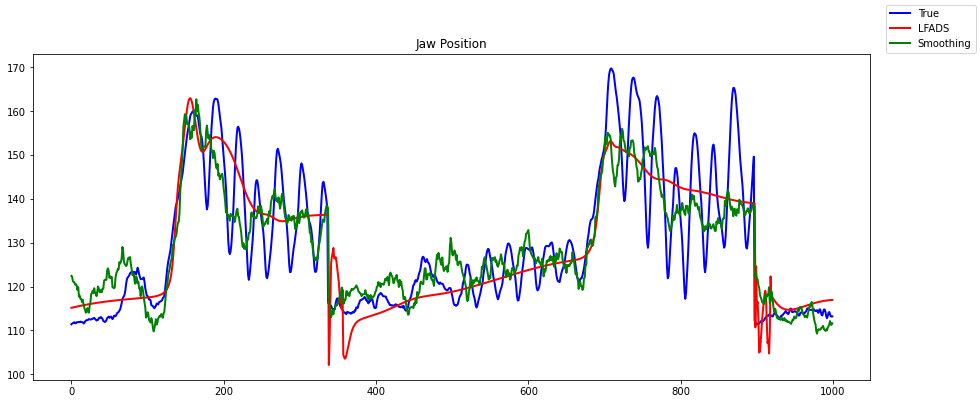

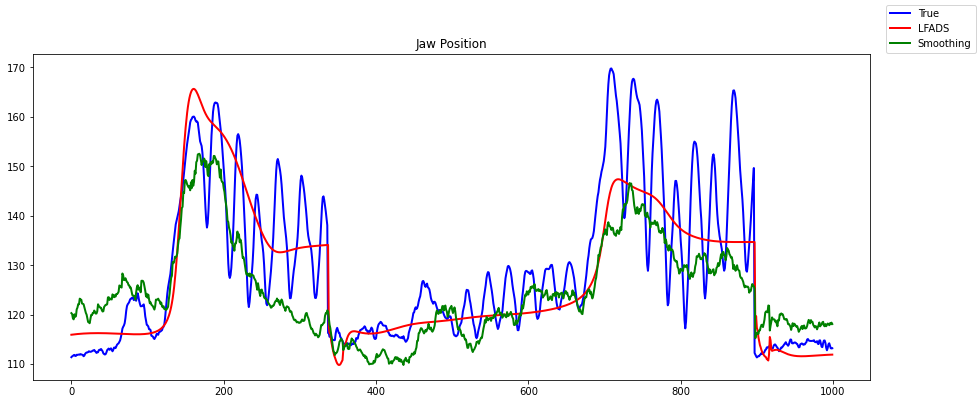

In [96]:
# Rates

nIdx = y_test.shape[0]
nIdx = nIdx - 1001
low = np.random.randint(0, high=nIdx)
randTime = np.arange(low,low+1000)

fig, ax = plt.subplots(1, 1,figsize=(15,6))
feat = 0
ax.plot(y_test[randTime,feat]+y_train_mean[feat],'b',lw=2,label='True')
ax.plot(y_test_pred_lfads_rates[randTime,feat]+y_train_mean[feat],'r',lw=2,label='LFADS')
ax.plot(y_test_pred_smooth_rates[randTime,feat]+y_train_mean[feat],'g',lw=2,label='Smoothing')

ax.set_title('Jaw Position')

fig.legend()
plt.show()

# Factors

fig, ax = plt.subplots(1, 1,figsize=(15,6))
feat = 0
ax.plot(y_test[randTime,feat]+y_train_mean[feat],'b',lw=2,label='True')
ax.plot(y_test_pred_lfads_factors[randTime,feat]+y_train_mean[feat],'r',lw=2,label='LFADS')
ax.plot(y_test_pred_smooth_factors[randTime,feat]+y_train_mean[feat],'g',lw=2,label='Smoothing')

ax.set_title('Jaw Position')

fig.legend()
plt.show()